# Forecasting
Forecasting using SKTime

# Import Required Packages

In [74]:
import warnings

import numpy as np
import pandas as pd

# hide warnings
warnings.filterwarnings("ignore")

# Basic Workflow

This section explains the basic forecasting workflows, and key interface points for it.

We cover the following four workflows:
- Basic deployment workflow: batch fitting and forecasting
- Basic evaluation workflow: evaluating a batch of forecasts against ground truth observations
- Advanced deployment workflow: fitting and rolling updates/forecasts
- Advanced evaluation workflow: using rolling forecast splits and computing split-wise and aggregate errors, including common back-testing schemes

All workflows make common assumptions on the input data format.

`sktime` uses `pandas` for representing time series:

- `pd.DataFrame` for time series and sequences, primarily. Rows represent time indices, columns represent variables.
- `pd.Series` can also be used for univariate time series and sequences
- `numpy` arrays (1D and 2D) can also be passed, but pandas use is encouraged.

The `Series.index` and `DataFrame.index` are used for representing the time series or sequence index. sktime supports pandas integer, period and timestamp indices for simple time series.

Use a textbook data set, the Box-Jenkins airline data set, which consists of the number of monthly totals of international airline passengers, from 1949 - 1960. Values are in thousands. See “Makridakis, Wheelwright and Hyndman (1998) Forecasting: methods and applications”

In [75]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

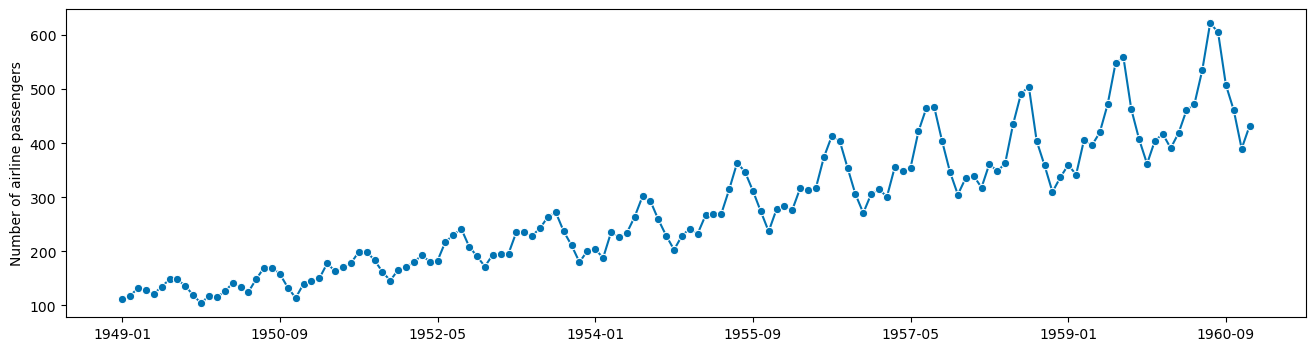

In [76]:
y = load_airline()

# plotting for visualization
plot_series(y)

In [77]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', length=144)

The simplest use case workflow is batch fitting and forecasting, i.e., fitting a forecasting model to one batch of past data, then asking for forecasts at time point in the future.

The steps in this workflow are as follows:
1. Preparation of the data
2. Specification of the time points for which forecasts are requested. This uses a `numpy.array` or the `ForecastingHorizon` object.
3. Specification and instantiation of the forecaster. This follows a scikit-learn-like syntax; forecaster objects follow the familiar scikit-learn BaseEstimator interface.
4. Fitting the forecaster to the data, using the forecaster’s fit method
5. Making a forecast, using the forecaster’s predict method

## 1. Preparing Data

In [78]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

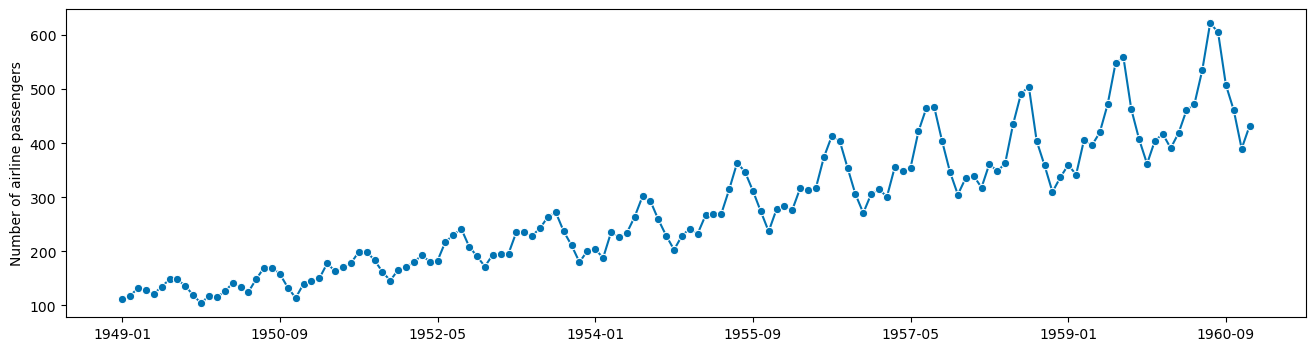

In [79]:
# in the example, we use the airline data set.
y = load_airline()
plot_series(y)

## 2. Define the Forecast Horizon

There are **two** main ways:

- Using a `numpy.array` of integers. This assumes either integer index or periodic index (`PeriodIndex`) in the time series; the integer indicates the _number of time_ points or periods ahead we want to make a forecast for. E.g., 1 means forecast the next period, 2 the second next period, and so on.
- Using a `ForecastingHorizon` object. This can be used to define forecast horizons, using any supported index type as an argument. No periodic index is assumed.

Forecasting horizons can be absolute, i.e., referencing specific time points in the future, or relative, i.e., referencing time differences to the present. As a default, the present is that latest time point seen in any `y` passed to the forecaster.

`numpy.array` based forecasting horizons are always relative; ForecastingHorizon objects can be both relative and absolute. In particular, absolute forecasting horizons can only be specified using ForecastingHorizon.



### Numpy Array Base Forecast Horizon

In [80]:
forecast_horizon = np.arange(1, 37)
forecast_horizon

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

Get only 2nd and 5th month ahead

In [81]:
forecast_horizon = np.array([2, 5])

### `ForecastingHorizon` Based Forecast

The `ForecastingHorizon` object takes absolute indices as input, but considers the input absolute or relative depending on the `is_relative` flag.

`ForecastingHorizon` will automatically assume a relative horizon if temporal difference types from pandas are passed; if value types from pandas are passed, it will assume an absolute horizon.

To define an absolute `ForecastingHorizon` in the example

In [82]:
from sktime.forecasting.base import ForecastingHorizon

In [83]:
forecast_horizon = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1961-01", periods=36, freq="M")), is_relative=False
)
forecast_horizon

ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', is_relative=False)

`ForecastingHorizon` objects can be converted from relative to absolute and back via the `to_relative` and `to_absolute` methods. Both of these conversions require a compatible `cutoff` to be passed.

In [84]:
cutoff = pd.Period("1960-12", freq="M")

In [85]:
forecast_horizon.to_relative(cutoff)

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
      dtype='int64', is_relative=True)

In [86]:
forecast_horizon.to_absolute(cutoff)

ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', is_relative=False)

## 3. Specify the Forecast Algorithm

To make forecasts, a forecasting algorithm needs to be specified. This is done using a `scikit-learn`-like interface. Most importantly, all `sktime` forecasters follow the same interface, so the preceding and remaining steps are the same, no matter which forecaster is being chosen.

We choose the naive forecasting method of predicting the last seen value. 

In [87]:
from sktime.forecasting.naive import NaiveForecaster

In [88]:
forecaster = NaiveForecaster(strategy="last")

### 4. Fitting the Forecaster to Pass Data

In [89]:
forecaster.fit(y)

NaiveForecaster()

### 5. Request Forecasting

This needs to be done after fitting the forecaster

In [90]:
y_pred = forecaster.predict(forecast_horizon)

Plot emperical data and prediction

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

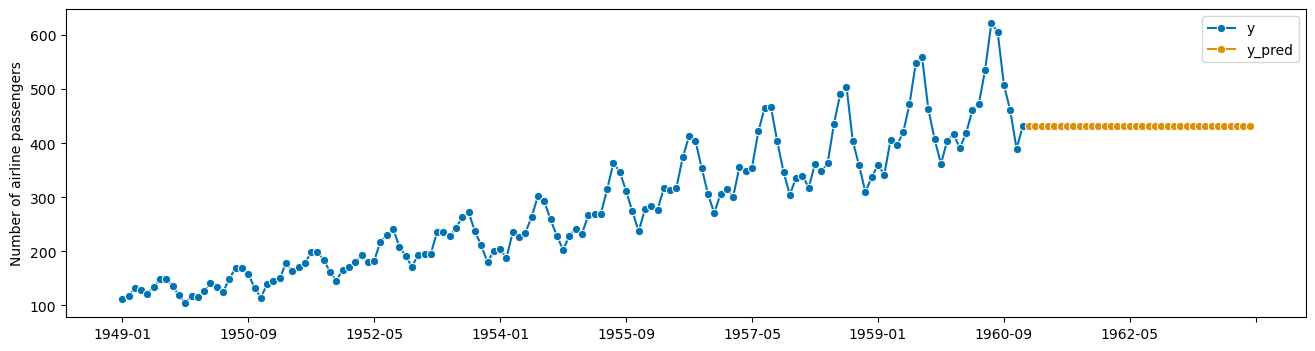

In [91]:
plot_series(y, y_pred, labels=["y", "y_pred"])

## Put Everything in One Shell

In [92]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

In [93]:
y = load_airline()
forecast_horizon = np.arange(1, 37)
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(forecast_horizon)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

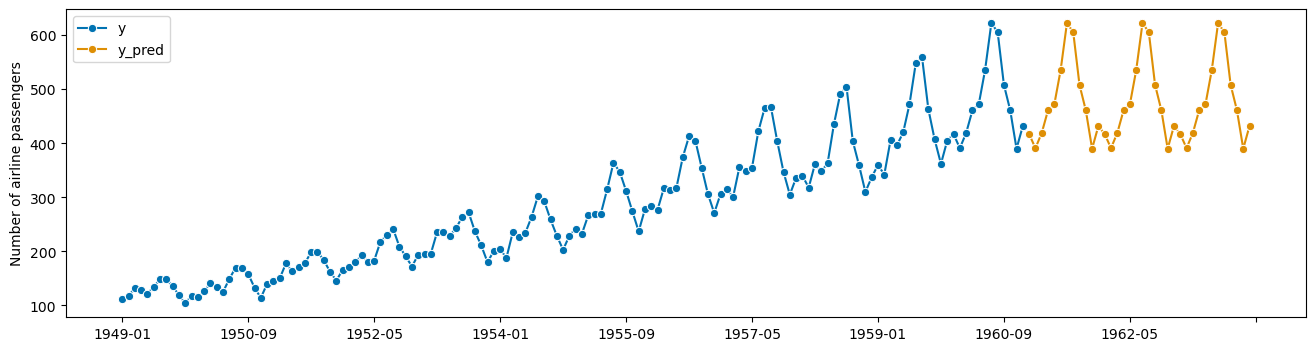

In [94]:
# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

# Forecasters that require the horizon already in `fit`
Some forecasters need the forecasting horizon provided already in `fit`. Such forecasters will produce informative error messages when it is not passed in fit. All forecaster will remember the horizon when already passed in fit for prediction.

In [95]:
# step 1: data specification
y = load_airline()

# step 2: specifying forecasting horizon
forecast_horizon = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y, forecast_horizon=forecast_horizon)

# step 5: querying predictions
y_pred = forecaster.predict()

TypeError: BaseForecaster.fit() got an unexpected keyword argument 'forecast_horizon'

In [ ]:
# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

 # Forecasters that can make use of exogeneous data
 Many forecasters can make use of exogeneous time series, i.e., other time series that are not forecast, but are useful for forecasting y. 
 
Exogeneous time series are always passed as an X argument, in fit, predict, and other methods. 

Exogeneous time series should always be passed as pandas.DataFrames. Most forecasters that can deal with exogeneous time series will assume that the time indices of X passed to fit are a super-set of the time indices in y passed to fit; and that the time indices of X passed to predict are a super-set of time indices in forecast_horizon, although this is not a general interface restriction. Forecasters that do not make use of exogeneous time series still accept the argument (and do not use it internally).

In [ ]:
# step 1: data specification
y = load_airline()
# we create some dummy exogeneous data
X = pd.DataFrame(index=y.index)

# step 2: specifying forecasting horizon
forecast_horizon = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y, X=X, forecast_horizon=forecast_horizon)

# step 5: querying predictions
y_pred = forecaster.predict(X=X)

Some forecasters that use exogeneous variables may also require the forecasting horizon only in predict. Such forecasters may also be called with steps 4 and 5 being

In [ ]:
forecaster.fit(y, X=X)
y_pred = forecaster.predict(forecast_horizon=forecast_horizon, X=X)

In [ ]:
plot_series(y, y_pred, labels=["y", "y_pred"])

# Multi Variable
Some forecasters are “genuine” multivariate, all others “apply by column”.

Below is an example of the general multivariate forecasting workflow, using the `VAR` (vector auto-regression) forecaster on the Longley dataset from `sktime.datasets`.

In [ ]:
from sktime.datasets import load_longley
from sktime.forecasting.var import VAR

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

forecaster = VAR()
forecaster.fit(y, forecast_horizon=[1, 2, 3])

y_pred = forecaster.predict()

In [96]:
y

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [97]:
y_pred

1961-01    417.0
1961-02    391.0
1961-03    419.0
1961-04    461.0
1961-05    472.0
1961-06    535.0
1961-07    622.0
1961-08    606.0
1961-09    508.0
1961-10    461.0
1961-11    390.0
1961-12    432.0
1962-01    417.0
1962-02    391.0
1962-03    419.0
1962-04    461.0
1962-05    472.0
1962-06    535.0
1962-07    622.0
1962-08    606.0
1962-09    508.0
1962-10    461.0
1962-11    390.0
1962-12    432.0
1963-01    417.0
1963-02    391.0
1963-03    419.0
1963-04    461.0
1963-05    472.0
1963-06    535.0
1963-07    622.0
1963-08    606.0
1963-09    508.0
1963-10    461.0
1963-11    390.0
1963-12    432.0
Freq: M, Name: Number of airline passengers, dtype: float64

There are two categories:

forecasters that are genuinely multivariate, such as `VAR`. Forecasts for one endogeneous (`y`) variable will depend on values of other variables.

forecasters that are univariate, such as `ARIMA`. Forecasts will be made by endogeneous (`y`) variable, and not be affected by other variables.

To display complete list of multivariate forecasters, search for forecasters with 'multivariate' or 'both' tag value for the tag `'scitype:y'`

In [98]:
from sktime.registry import all_estimators

for forecaster in all_estimators(filter_tags={"scitype:y": ["multivariate", "both"]}):
    print(forecaster[0])

Univariate forecasters have tag value 'univariate', and will fit one model per column. To access the column-wise models, access the `forecasters_` parameter, which stores the fitted forecasters in a pandas DataFrame, fitted forecasters being in the column with the variable for which the forecast is being made.

In [99]:
from sktime.datasets import load_longley
from sktime.forecasting.arima import ARIMA

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

forecaster = ARIMA()
forecaster.fit(y, forecast_horizon=[1, 2, 3])

forecaster.forecasters_

TypeError: BaseForecaster.fit() got an unexpected keyword argument 'forecast_horizon'

# Probabilistic forecasting: prediction intervals, quantile, variance, and distributional forecasts
sktime provides a unified interface to make probabilistic forecasts. The following methods are possibly available for probabilistic forecasts:
- `predict_interval` produces interval forecasts. Additionally to any predict arguments, an argument coverage (nominal interval coverage) must be provided.
- `predict_quantiles` produces quantile forecasts. Additionally to any predict arguments, an argument alpha (quantile values) must be provided.
- `predict_var` produces variance forecasts. This has same arguments as predict.
- `predict_proba` produces full distributional forecasts. This has same arguments as predict.

Not all forecasters are capable of returning probabilistic forecast, but if a forecasters provides one kind of probabilistic forecast, it is also capable of returning the others. The list of forecasters with such capability can be queried by registry.all_estimators, searching for those where the `capability:pred_int` tag has value `True`.

The basic workflow for probabilistic forecasts is similar to the basic forecasting workflow, with the difference that instead of predict, one of the probabilistic forecasting methods is used

In [100]:
import numpy as np
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster

In [101]:
y = load_airline()
forecast_horizon = np.arange(1, 13)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y, forecast_horizon=forecast_horizon)

TypeError: BaseForecaster.fit() got an unexpected keyword argument 'forecast_horizon'

## Interval Prediction Using `predict_interval`

`predict_interval` takes an argument `coverage`, which is a `float` (or list of floats), the nominal coverage of the prediction interval(s) queried. predict_interval produces symmetric prediction intervals.

The return is a pandas dataframe with schema as following:
- The first level is variable name from y in fit (or Coverage if no variable names were present), 
- second level coverage fractions for which intervals were computed, in the same order as in input coverage; 
- third level columns lower and upper. Rows are the indices for which forecasts were made (same as in y_pred or forecast_horizon). 
- Entries are lower/upper (as column name) bound of the nominal coverage predictive interval for the index in the same row.



In [102]:
y_pred_ints = forecaster.predict_interval(coverage = 0.9)
y_pred_ints

NotFittedError: This instance of ThetaForecaster has not been fitted yet; please call `fit` first.

Plot the sequence

In [ ]:
from sktime.utils import plotting

# also requires predictions
y_pred = forecaster.predict()

fig, ax = plotting.plot_series(
    y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_ints
)

## Quartile Prediction Using `predict_quartile`
`predict_quantiles` as a unified interface to return quantile values of predictions. The output is a pandas dataframe

`predict_quantiles` has an argument alpha, containing the quantile values being queried. Similar to the case of the predict_interval, alpha can be a float, or a list of floats.

Remark: for clarity: quantile and (symmetric) interval forecasts can be translated into each other as follows.
- **alpha < 0.5**: The alpha-quantile prediction is equal to the lower bound of a predictive interval with coverage = $(0.5 - \alpha) * 2$
- **alpha > 0.5**: The alpha-quantile prediction is equal to the upper bound of a predictive interval with coverage = $(\alpha - 0.5) * 2$


In [103]:
y_pred_quantiles = forecaster.predict_quantiles(alpha=[0.275, 0.975])
y_pred_quantiles

NotFittedError: This instance of ThetaForecaster has not been fitted yet; please call `fit` first.

## Variance Prediciton Using `predict_variance`
entries are not point predictions but variance predictions.

In [ ]:
y_pred_var = forecaster.predict_var()
y_pred_var

## Distribution Prediction with `predict_proba`
To predict full predictive distributions, `predict_proba` can be used. 

As this returns tensorflow distribution objects, the deep learning dependency set `dl` of sktime (which includes `tensorflow` and `tensorflow-probability` dependencies) must be installed.

Distributions returned by `predict_proba` are by default marginal at time points, not joint over time points. More precisely, the returned Distribution object is formatted and to be interpreted as follows: * Batch shape is 1D and same length as forecast_horizon * Event shape is 1D, with length equal to number of variables being forecast * i-th (batch) distribution is forecast for i-th entry of forecast_horizon * j-th (event) component is j-th variable, same order as y in $fit/update$

To return joint forecast distributions, the marginal parameter can be set to `False` (currently work in progress). In this case, a distribution with 2D event shape $(len(fh), len(y))$ is returned.

In [104]:
y_pred_proba = forecaster.predict_proba()
y_pred_proba

NotFittedError: This instance of ThetaForecaster has not been fitted yet; please call `fit` first.

## Panel Forcast and Hierarchical Forcast

All sktime forecasters can be applied to panel and hierarchical data, which needs to be presented in specific input formats. Forecasters that are not genuinely panel or hierarchical forecasters will be applied by instance.

The recommended (not the only) format to pass panel and hierarchical data is a pandas dataframe with `MultiIndex` row. In this `MultiIndex`, the last level must be in a `sktime` compatible time index format, the remaining levels are panel or hierarchy nodes.



In [105]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

y = _bottom_hier_datagen(no_levels=2)
y

passengers
l2_agg    l1_agg    timepoints             
l2_node01 l1_node02 1949-01     1322.900000
                    1949-02     1428.380000
                    1949-03     1688.500000
                    1949-04     1631.110000
                    1949-05     1482.470000
...                                     ...
l2_node02 l1_node05 1960-08     7160.477710
                    1960-09     5963.349540
                    1960-10     5393.683591
                    1960-11     4539.035315
                    1960-12     5043.718055

[864 rows x 1 columns]

As stated, all **forecasters**, genuinely hierarchical or not, can be applied, with all workflows described in this section, to produce hierarchical forecasts.

The syntax is exactly the same as for plain time series, except for the hierarchy levels in input and output data

In [106]:
from sktime.forecasting.arima import ARIMA

forecast_horizon = [1, 2, 3]

forecaster = ARIMA()
forecaster.fit(y, forecast_hori=forecast_horizon)
forecaster.predict()

TypeError: BaseForecaster.fit() got an unexpected keyword argument 'forecast_hori'

forecasters that are **not genuinely hierarchical** fit by instance. 

The forecasters fitted by instance can be accessed in the `forecasters_ parameter`, which is a pandas dataframe where forecasters for a given instance are placed in the row with the index of the instance for which they make forecasts:

In [107]:
forecaster.forecasters_

AttributeError: 'ARIMA' object has no attribute 'forecasters_'

If the data is both hierarchical and multivariate, and the forecaster cannot genuinely deal with either, the `forecasters_` attribute will have both column indices, for variables, and row indices, for instances, with forecasters fitted per instance and variable

In [108]:
from sktime.forecasting.arima import ARIMA
from sktime.utils._testing.hierarchical import _make_hierarchical

y = _make_hierarchical(n_columns=2)

forecast_horizon = [1, 2, 3]

forecaster = ARIMA()
forecaster.fit(y, fh=forecast_horizon)

forecaster.forecasters_

c0       c1
h0_0 h1_0  ARIMA()  ARIMA()
     h1_1  ARIMA()  ARIMA()
     h1_2  ARIMA()  ARIMA()
     h1_3  ARIMA()  ARIMA()
h0_1 h1_0  ARIMA()  ARIMA()
     h1_1  ARIMA()  ARIMA()
     h1_2  ARIMA()  ARIMA()
     h1_3  ARIMA()  ARIMA()

## Example
Use the same airline data, instead of predicting the next 3 years, we hold out the last 3 years of the airline data in `y_test`, and see how the forecaster would have performed three years ago, when asked to forecast the most recent 3 years (`y_pred`), from the years before (`y_train`), measured by a quantitative performance metric (`mean_absolute_percentage_error`). 

This is then considered as an indication of how well the forecaster would perform in the coming 3 years. This may or may not be a stretch depending on statistical assumptions and data properties 

Caution: it often is a stretch - past performance is in general not indicative of future performance)

### Step 1: Train and Test split Using Temporal Information 

In [109]:
from sktime.split import temporal_train_test_split

In [110]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)

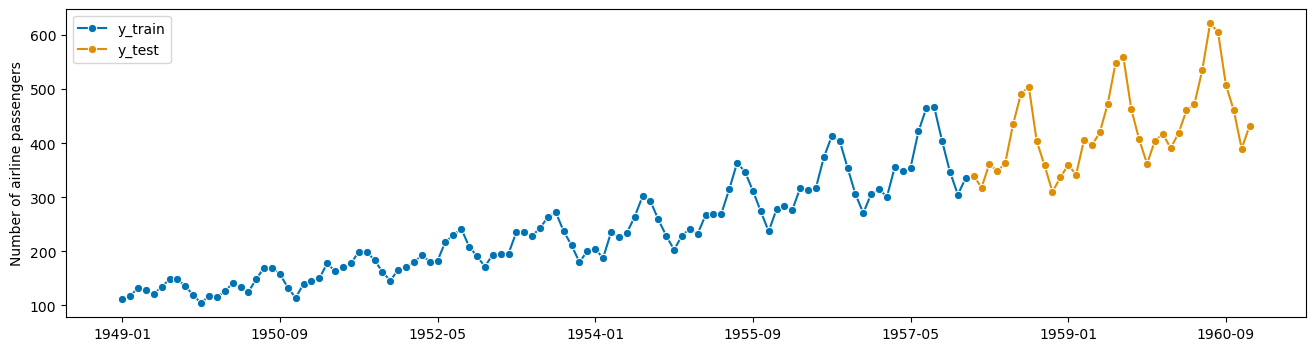

In [111]:
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

### Step 2: Make Forecast For `y_train` and `y_pred`

In [112]:
# we can simply take the indices from `y_test` where they already are stored
forecast_horizon = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train)

# y_pred will contain the predictions
y_pred = forecaster.predict(forecast_horizon)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

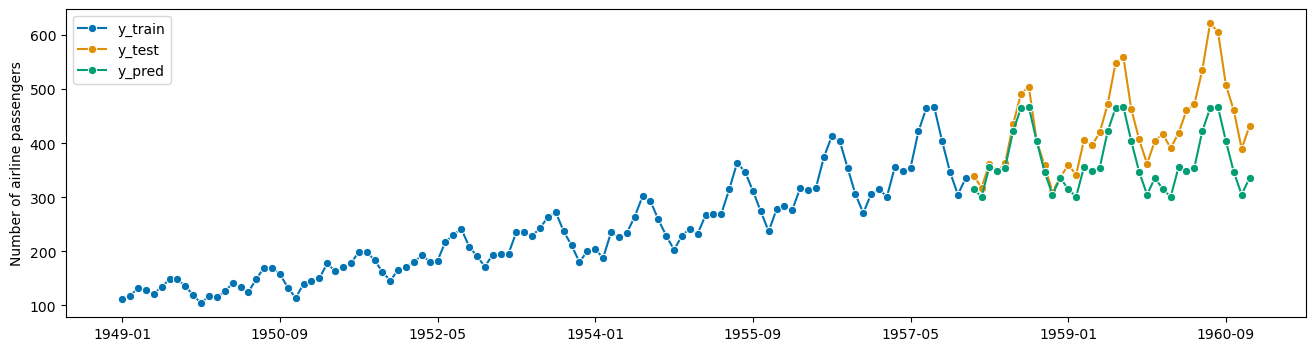

In [113]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

## Steps 3 and 4 - Specifying a forecasting metric, evaluating on the test set

Now specify a forecasting metric. These are functions that return a number when input with prediction and actual series. 

They are different from `sklearn` metrics in that they accept series with indices rather than `np.arrays`. Forecasting metrics can be invoked in two ways:
- Using the **lean function interface**, e.g., mean_absolute_percentage_error which is a python function `(y_true : pd.Series, y_pred : pd.Series) -> float`
- Using the **composable class interface**, e.g., MeanAbsolutePercentageError, which is a python class, callable with the same signature


In [114]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

Option 1: using the lean function interface

*note*: the FIRST argument is the ground truth, the SECOND argument are the forecasts, the order matters for most metrics in general.

In [115]:
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.13189432350948402

To properly interpret numbers like this, it is useful to understand properties of the metric in question (e.g., lower is better), and to compare against suitable baselines and contender algorithms

Option 2: Using the composable class interface

In [116]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [117]:
mape = MeanAbsolutePercentageError(symmetric=False)

The class interface allows to easily construct variants of the MAPE e.g., the non-symmetric version
It also allows for inspection of metric properties, e.g., are higher values better (answer: no)?

In [118]:
mape.get_tag("lower_is_better")

True

Evaluation works exactly like in option 2, but with the instantiated object

In [119]:
mape(y_test, y_pred)

0.13189432350948402

NOTE: Some metrics, such as `mean_absolute_scaled_error`, also require the training set for evaluation. In this case, the training set should be passed as a `y_train` argument. Refer to the API reference on individual metrics.

NOTE: The workflow is the same for forecasters that make use of exogeneous data - no X is passed to the metrics.

## Step 5: Testing Performance Against Benchmarks

The basic batch forecast evaluation workflow in a nutshell - function metric interface

In [120]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split

Step 1: Spliting Historical Data

In [121]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)

# step 3: specifying the evaluation metric and
# step 4: computing the forecast performance
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

# step 5: testing forecast performance against baseline
# under development

0.13189432350948402

Step 2: Running the basic forcasting workflow

In [122]:
forecast_horizon = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(forecast_horizon)

Step 3: Specify the evaluation matrix by creating the MAPE object

In [123]:
mape = MeanAbsolutePercentageError(symmetric=False)

Step 4: computing the forecast performance

*Note:* If function interface is used, specify it here

In [124]:
mape(y_test, y_pred)

0.13189432350948402

The general pattern is as follows:

1. Specify a forecasting strategy
2. Specify a relative forecasting horizon
3. Fit the forecaster to an initial batch of data using fit
4. Make forecasts for the relative forecasting horizon, using predict
5. Obtain new data; use update to ingest new data
6. Make forecasts using predict for the updated data

Repeat 5 and 6 as often as required

Example: suppose that, in the airline example, we want to make forecasts a year ahead, but every month, starting December 1957. The first few months, forecasts would be made as follows:

In [125]:
from sktime.datasets import load_airline
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series

Load full dataset for convenience

In [126]:
y = load_airline()

In [127]:
# Dec 1957, the number is manually calculated
y_1957Dec = y[:-36]

1. Specify the forecasting strategy

In [128]:
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

2. Specify the forecast horizon: future 1 year, all months

In [129]:
forecast_horizon = np.arange(1,13)

3. Fit the model due to initial use

In [130]:
forecaster.fit(y_1957Dec)

AutoETS(auto=True, n_jobs=-1, sp=12)

4. Obtaining the first batch of forecasts for Jan 1958 - Dec 1958

In [131]:
y_pred_1957Dec = forecaster.predict(forecast_horizon)

Plotting predicitons and past data

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

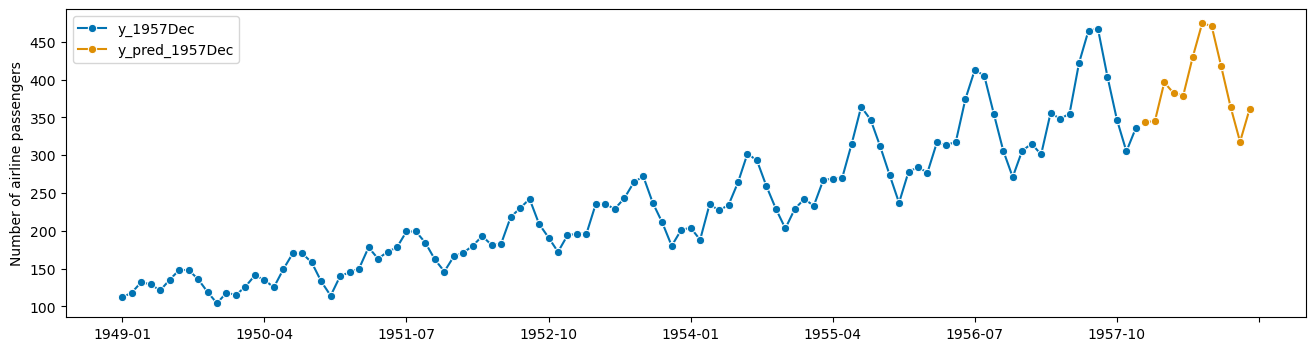

In [132]:
plot_series(y_1957Dec, y_pred_1957Dec, labels=["y_1957Dec", "y_pred_1957Dec"])

Information for January 1958

In [133]:
# new data is observed:
y_1958Jan = y[[-36]]

# step 5: we update the forecaster with the new data
forecaster.update(y_1958Jan)

# step 6: making forecasts with the updated data
y_pred_1958Jan = forecaster.predict(forecast_horizon)

In [134]:
y_pred_1958Jan

1958-02    341.519832
1958-03    392.856950
1958-04    378.530448
1958-05    375.671344
1958-06    426.022002
1958-07    470.590329
1958-08    467.122823
1958-09    414.471996
1958-10    360.974833
1958-11    315.219631
1958-12    357.915467
1959-01    363.050977
Freq: M, Name: Number of airline passengers, dtype: float64

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

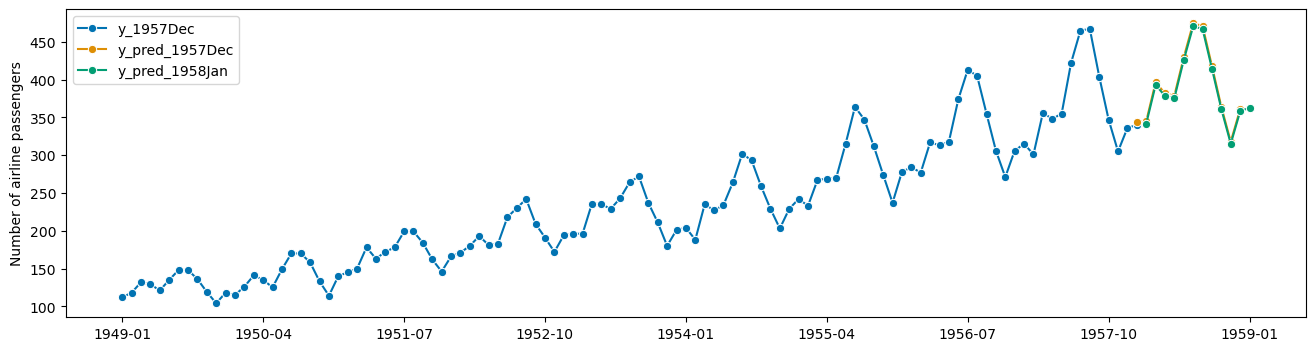

In [135]:
# plotting predictions and past data
plot_series(
    y[:-35],
    y_pred_1957Dec,
    y_pred_1958Jan,
    labels=["y_1957Dec", "y_pred_1957Dec", "y_pred_1958Jan"],
)

In [136]:
# February 1958

# new data is observed:
y_1958Feb = y[[-35]]

# step 5: we update the forecaster with the new data
forecaster.update(y_1958Feb)

# step 6: making forecasts with the updated data
y_pred_1958Feb = forecaster.predict(forecast_horizon)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

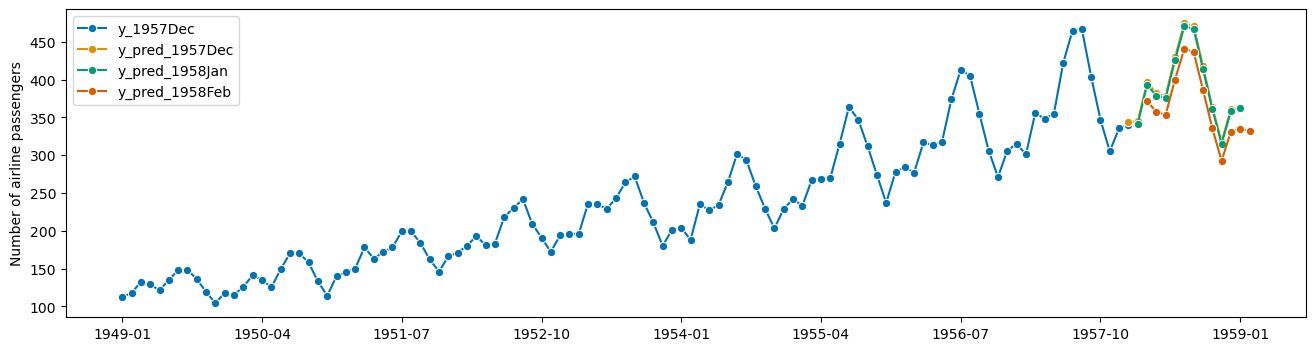

In [137]:
# plotting predictions and past data
plot_series(
    y[:-35],
    y_pred_1957Dec,
    y_pred_1958Jan,
    y_pred_1958Feb,
    labels=["y_1957Dec", "y_pred_1957Dec", "y_pred_1958Jan", "y_pred_1958Feb"],
)

A shorthand for running first `update` and then predict is `update_predict_single` - for some algorithms, this may be more efficient than the separate calls to `update` and `predict`:

In [138]:
# March 1958

# new data is observed:
y_1958Mar = y[[-34]]

# step 5&6: update/predict in one step
forecaster.update_predict_single(y_1958Mar, fh=forecast_horizon)

1958-04    349.161871
1958-05    346.918718
1958-06    394.050821
1958-07    435.840641
1958-08    433.318525
1958-09    384.849118
1958-10    335.541888
1958-11    293.179567
1958-12    333.282316
1959-01    338.600206
1959-02    336.987376
1959-03    388.126176
Freq: M, Name: Number of airline passengers, dtype: float64

In the rolling deployment mode, may be useful to move the estimator’s “now” state (the `cutoff`) to later, for example if no new data was observed, but time has progressed; or, if computations take too long, and forecasts have to be queried.

The update interface provides an option for this, via the update_params argument of update and other update functions.

If `update_params` is set to `False`, no model update computations are performed; only data is stored, and the internal “now” state (the `cutoff`) is set to the most recent date.



In [139]:
# April 1958

# new data is observed:
y_1958Apr = y[[-33]]

# step 5: perform an update without re-computing the model parameters
forecaster.update(y_1958Apr, update_params=False)

AutoETS(auto=True, n_jobs=-1, sp=12)

## Advanced Forecasting

To evaluate forecasters with respect to their performance in rolling forecasting, the forecaster needs to be tested in a set-up mimicking rolling forecasting, usually on past data.

The advanced evaluation workflow can be carried out using the `evaluate` benchmarking function. 
evaluate takes as arguments: 
- a `forecaster` to be evaluated 
- a `scikit-learn` re-sampling strategy for temporal splitting (cv below), e.g., `ExpandingWindowSplitter` or `SlidingWindowSplitter` 
- a `strategy` (string): whether the forecaster should be always be refitted or just fitted once and then updated



In [140]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter

In [141]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.061710,2.085515,0.004699,72,1954-12
1,0.050042,2.195949,0.004367,84,1955-12
2,0.029802,3.334582,0.003958,96,1956-12
3,0.053773,1.417028,0.003843,108,1957-12
4,0.073820,2.011578,0.004458,120,1958-12
5,0.030976,4.390653,0.004569,132,1959-12


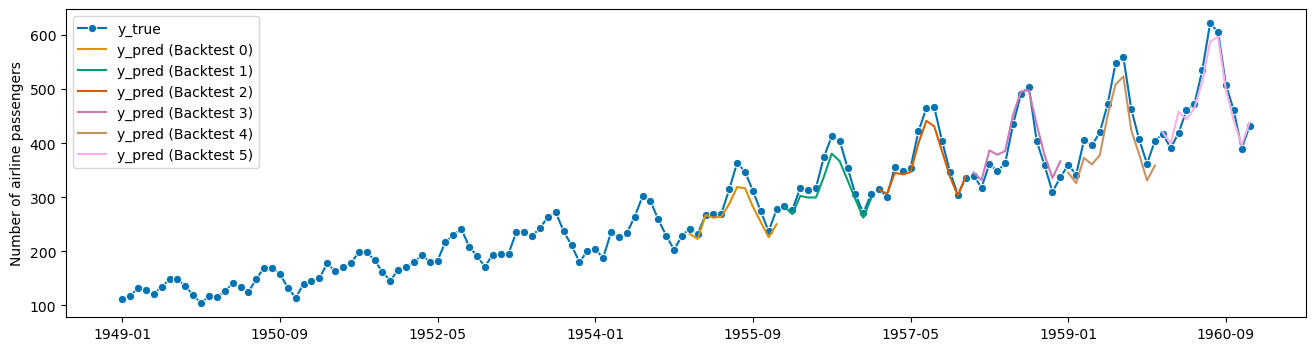

In [142]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

# Forecasters in `sktime` - lookup, properties, main families

This section summarizes how to:
- Search for forecasters in sktime
- Properties of forecasters, corresponding search options and tags
- Commonly used types of forecasters in `sktime`

Generally, all forecasters available in `sktime` can be listed with the `all_estimators` command.

This will list all forecasters in `sktime`, even those whose soft dependencies are not installed.

The entries of the last column of the resulting dataframe are classes which could be directly used for construction, or simply inspected for the correct import path.

In [143]:
from sktime.registry import all_estimators

all_estimators("forecaster", as_dataframe=True)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
2,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
3,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
4,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
...,...,...
74,VAR,<class 'sktime.forecasting.var.VAR'>
75,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
76,VECM,<class 'sktime.forecasting.vecm.VECM'>
77,YfromX,<class 'sktime.forecasting.compose._reduce.Yfr...


For logic that loops over forecasters, the default output format may be more convenient:

In [145]:
forecaster_list = all_estimators("forecaster", as_dataframe=False)

# this returns a list of (name, estimator) tuples
forecaster_list[0]

('ARCH', sktime.forecasting.arch._uarch.ARCH)

## Forecaster Tag

Every forecaster has tags, which are key-value pairs that can describe capabilities or internal implementation details.

The most important "capability" style tags are the following:

`requires-fh-in-fit` - a boolean. Whether the forecaster requires the forecasting horizon `fh` already in `fit` (`True`), or whether it can be passed late in `predict` (`False`).

`scitype:y` - a string. Whether the forecaster is univariate (`"univariate"`), strictly multivariate (`"multivariate"`), or can deal with any number of variables (`"both"`).

`capability:pred_int` - a boolean. Whether the forecaster can return probabilistic predictions via `predict_interval` etc, see Section 1.5.

`ignores-exogeneous-X` - a boolean. Whether the forecaster makes use of exogeneous variables `X` (`False`) or not (`True`). If the forecaster does not use `X`, it can still be passed for interface uniformity, and will be ignored.

`handles-missing-data` - a boolean. Whether the forecaster can deal with missing data in the inputs `X` or `y`.

Tags of a forecaster instance can be inspected via the `get_tags` (lists all tags) and `get_tag` (gets value for one tag) methods.

Tag values may depend on hyper-parameter choices.

In [146]:
from sktime.forecasting.arima import ARIMA

ARIMA().get_tags()

{'python_dependencies_alias': {'scikit-learn': 'sklearn'},
 'authors': ['mloning', 'hyang1996', 'fkiraly', 'ilkersigirci'],
 'maintainers': ['hyang1996'],
 'python_version': None,
 'python_dependencies': 'pmdarima',
 'object_type': 'forecaster',
 'scitype:y': 'univariate',
 'ignores-exogeneous-X': False,
 'capability:insample': True,
 'capability:pred_int': True,
 'capability:pred_int:insample': True,
 'handles-missing-data': True,
 'y_inner_mtype': 'pd.Series',
 'X_inner_mtype': 'pd.DataFrame',
 'requires-fh-in-fit': False,
 'X-y-must-have-same-index': True,
 'enforce_index_type': None,
 'fit_is_empty': False}

The `y_inner_mtype` and `X_inner_mtype` indicate whether the forecaster can deal with panel or hierarchical data natively - if an panel or hierarchical mtype occurs here, it does (see data types tutorial).

An explanation for all tags can be obtained using the `all_tags` utility

To list forecasters with their tags, the `all_estimators` utility can be used with its `return_tags` argument.

The resulting data frame can then be used for table queries or sub-setting.

In [147]:
from sktime.registry import all_estimators

all_estimators(
    "forecaster", as_dataframe=True, return_tags=["scitype:y", "requires-fh-in-fit"]
)

,name,object,scitype:y,requires-fh-in-fit
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>,univariate,False
1,ARDL,<class 'sktime.forecasting.ardl.ARDL'>,univariate,False
2,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...,univariate,False
3,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...,univariate,False
4,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>,univariate,False
...,...,...,...,...
74,VAR,<class 'sktime.forecasting.var.VAR'>,multivariate,False
75,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>,multivariate,False
76,VECM,<class 'sktime.forecasting.vecm.VECM'>,multivariate,False
77,YfromX,<class 'sktime.forecasting.compose._reduce.Yfr...,univariate,False


To filter beforehand on certain tags and tag values, the `filter_tags` argument can be used:

In [148]:
# this lists all forecasters that can deal with multivariate data
all_estimators(
    "forecaster", as_dataframe=True, filter_tags={"scitype:y": ["multivariate", "both"]}
)

,name,object
0,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
1,DynamicFactor,<class 'sktime.forecasting.dynamic_factor.Dyna...
2,EnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.E...
3,FallbackForecaster,<class 'sktime.forecasting.compose._fallback.F...
4,FhPlexForecaster,<class 'sktime.forecasting.compose._fhplex.FhP...
5,ForecastByLevel,<class 'sktime.forecasting.compose._grouped.Fo...
6,ForecastKnownValues,<class 'sktime.forecasting.dummy.ForecastKnown...
7,ForecastX,<class 'sktime.forecasting.compose._pipeline.F...
8,ForecastingGridSearchCV,<class 'sktime.forecasting.model_selection._tu...
9,ForecastingPipeline,<class 'sktime.forecasting.compose._pipeline.F...


Important note: as said above, tag values can depend on hyper-parameter settings, e.g., a `ForecastingPipeline` can handle multivariate data only if the forecaster in it can handle multivariate data.

In retrieval as above, the tags for a class are usually set to indicate the most general potential value, e.g., if for some parameter choice the estimator can handle multivariate, it will appear on the list.


To list all forecaster tags with an explanation of the tag, the `all_tags` utility can be used:

In [149]:
import pandas as pd

from sktime.registry import all_tags

# wrapping this in a pandas DataFrame for pretty display
pd.DataFrame(all_tags(estimator_types="forecaster"))[[0, 3]]

,0,3
0,X-y-must-have-same-index,do X/y in fit/update and X/fh in predict have ...
1,X_inner_mtype,which machine type(s) is the internal _fit/_pr...
2,authors,"list of authors of the object, each author a G..."
3,capability:insample,can the forecaster make in-sample predictions?
4,capability:pred_int,does the forecaster implement predict_interval...
5,capability:pred_int:insample,can the forecaster make in-sample predictions ...
6,capability:pred_var,does the forecaster implement predict_variance?
7,distribution_type,distribution type of data as str
8,enforce_index_type,"passed to input checks, input conversion index..."
9,fit_is_empty,fit contains no logic and can be skipped? Yes=...
